# Classifying Handwritten Digits

In this project, we will train and explore the effectiveness of a deep, feedforward neural network to classify images.

Image classification is a difficult task. When it comes to training a neural network for images, each image in the training set is high dimensional. Each pixel in an image is a single feature in a separate column. For example, one 128 X 128 image has 16,384 features. When it comes to utilizing actual images, they are typically of higher resolution. For example, 3264 X 2448 pixels. This would total about 8 million features. To make matters even more complicated, images don't have an obvious linear or nonlinear relationship that can be learned through models like linear or logistic regression. 

When it comes to learning image classification, deep learning is effective because of the models' ability to learn hierarchical representations. Each hidden layer will focus on specific features of the image and each successive layer will use weights from the previous layers to try to learn more complex representations.

Hopefully in this project, we will be able to build a functional deep neural network that can succesfully identity digits within images. 

We will begin this project by utilizing a dataset that is pre-loaded into the <code>sklearn.datasets</code> library. We'll use the <code>load_digits()</code> function to return a copy of the hand-written digits dataset from UCI.

Since our dataset will be a tabular representation of data, each image will be represented as a row of pixel values. In order to visualize the original image, we'll have to reshape these pixel values back into the original dimensions (28 X 28 pixels). We can accomplish this by using the <code>numpy.reshape()</code> function to reshape the training example into a numpy array. We will then visualize the image with the <code>pyplot.imshow()</code> function. If we want to visualize multiple images, we can utilize the <code>axes.imshow()</code> function.

We will now load libraries and the dataset to visualize some of the images.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
digits = load_digits()

In [3]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
labels = pd.DataFrame(digits['target'])
data = pd.DataFrame(digits['data'])

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Now that we have the data imported in, let's visualize what the first row looks like as the original image.

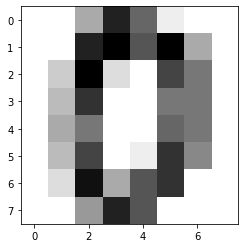

In [6]:
original_first_image = data.iloc[0].values.reshape(8,8)
plt.imshow(original_first_image, cmap='gray_r')

That looks like a zero, let's double check the label for the first row.

In [7]:
print('The first row target is: ',labels.iloc[0].values[0])

The first row target is:  0


Let's visualize a few more rows.

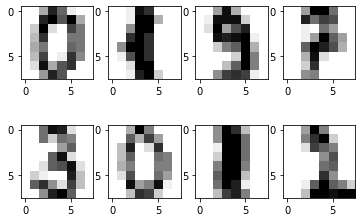

In [8]:
fig,ax = plt.subplots(2,4)
first_row = [0,99,199,299]
second_row = [999,1099,1199,1299]

for i,val in enumerate(first_row):
    ax[0,i].imshow(data.iloc[val].values.reshape(8,8),cmap='gray_r',label='word')
    
for i, val in enumerate(second_row):
    ax[1,i].imshow(data.iloc[val].values.reshape(8,8),cmap='gray_r')

A few of those are even hard to decipher to the naked eye. For example, the last digit in the second row looks like a either a 1 or a 2, let's check.

In [9]:
labels.iloc[1299].values[0]

2

It was a 2! It will be interesting to see how machine learning algorithms classify these images given that even to our own eye, it's difficult to tell.

### K-Nearest Neighbor
Since we can not use linear or logisitic regression since those make assumptions about the linearity between the features and the output, k-nearest neighbor does not. K-Nearest neighbor just compares every unseen observation in the test set to the training observations to look for similar/nearest observations. The amount of nearest observations the model uses is specified by us. Once it finds the label with the most nearby observations, it assigns that value as the prediction.

Before we dive into deep neural networks, let's experiment with the KNN model. We'll create a pipeline of functions that allow up to train, test, and cross validate our data using the KNN model.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import accuracy_score

def train_knn(train_features,train_labels,neighbors):
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(train_features,np.ravel(train_labels))
    return knn

def test_knn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    df = pd.DataFrame()
    accuracy = accuracy_score(test_labels,predictions)
    return accuracy

def cross_validate(neighbors):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2, shuffle = True)
    for train_index, test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index],labels.loc[test_index]
        model = train_knn(train_features,train_labels,neighbors)
        overall_accuracy = test_knn(model,test_features,test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

knn_one_neighbor = cross_validate(1)
print('Overall Accuracy: ', np.mean(knn_one_neighbor))

Overall Accuracy:  0.9888728037614452


Using a 4 Fold Cross Validation, with just one neighbor, we were able to gain a pretty impressive 98.8% accuracy rate. Reusing our 4 Fold Cross Validation, we should adjust the number of neighbors to see how it affects our overall accuracy rate.

In [11]:
accuracies = []
for i in range(1,10):
    accuracy = cross_validate(i)
    accuracies.append(np.mean(accuracy))

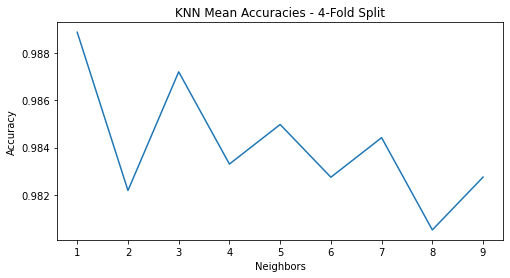

In [12]:
plt.figure(figsize = (8,4))
plt.plot(range(1,10),accuracies)
plt.title('KNN Mean Accuracies - 4-Fold Split')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.show()

With one neighbor, we retain the highest accuracy level, but despite cross validation, we can still be overfitting the data since we only have 1,797 total rows of data.

We still do have high accuracy, however it's impossible to debug and explore the results since no model actually was created or learned anything. It was all instance based predictions. KNN uses very high memory usage and would start to breakdown with more data and larger image resolutions.

### Neural Network with a Single Hidden Layer
Since we're interested in an accurate and scalable model, we can begin training and testing a Neural Network. We'll begin with a single hidden layer and experiment with the size of the hidden layer by increasing the number of neurons.

In [13]:
from sklearn.neural_network import MLPClassifier

def train_nn(train_features,train_labels,neurons):
    nn = MLPClassifier(hidden_layer_sizes = neurons, max_iter = 1000)
    nn.fit(train_features,np.ravel(train_labels))
    return nn

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels,predictions)
    return accuracy

def train_vs_test_nn(model,train_features, train_labels,
                     test_features,test_labels):
    train_predictions = model.predict(train_features)
    test_predictions = model.predict(test_features)
    train_accuracy = accuracy_score(train_labels,train_predictions)
    test_accuracy = accuracy_score(test_labels,test_predictions)
    return train_accuracy, test_accuracy

def cross_validate(neurons):
    train_fold_accuracies = []
    test_fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2, shuffle = True)
    for train_index, test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index],labels.loc[test_index]
        model = train_nn(train_features,train_labels,neurons)
        train_accuracy, test_accuracy = train_vs_test_nn(model,train_features, train_labels,
                                                test_features,test_labels)
        train_fold_accuracies.append(train_accuracy)
        test_fold_accuracies.append(test_accuracy)
    return train_fold_accuracies, test_fold_accuracies

/Users/WordApparel/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/WordApparel/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


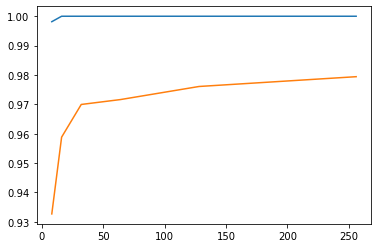

In [14]:
nn_neurons = [(8,),(16,),(32,),(64,),(128,),(256,)]

nn_train_accuracies = []
nn_test_accuracies = []
for neuron in nn_neurons:
    train_accuracy,test_accuracy = cross_validate(neuron)
    nn_train_accuracies.append(np.mean(train_accuracy))
    nn_test_accuracies.append(np.mean(test_accuracy))

plt.plot([i[0] for i in nn_neurons],nn_train_accuracies)
plt.plot([i[0] for i in nn_neurons],nn_test_accuracies)

In [15]:
print('train mean accuracies: ',nn_train_accuracies)
print('test mean accuracies: ',nn_test_accuracies)

train mean accuracies:  [0.9981454005934718, 1.0, 1.0, 1.0, 1.0, 1.0]
test mean accuracies:  [0.9326713684731502, 0.9588183617916357, 0.9699529819351645, 0.9716233605543182, 0.9760764662212323, 0.979412274189557]


It looks like as we increased the number of neurons, the accuracy generally improved in the test set. Since the accuracy level of the KNN model was 98%, it doesn't seem like we gained all that much from using a single hidden layer neural network.

More importantly, when comparing the training set predictions to the test set predictions, the model clearly overfit the training data with 100% accuracy amongst almost all neuron values. This single layer neural networks has very high variance and although it still performed well on the test set with cross validation, there may not be enough data to truly test the model effectively. 

Since we do not have more data currently, let's try adding additional layers to the neural network. It may help prevent overfitting the training data.

### Neural Network with 2 Hidden Layers
Now that we trained and tested multiple neuron amounts with a single hidden layer and didn't score higher than KNN, as well as, overfitting the data. Let's try 2 hidden layers and this time, we'll only try 64 neurons.

In [16]:
train_accuracy_nn_2_layers, test_accuracy_nn_2_layers = cross_validate((64,64))
print(train_accuracy_nn_2_layers)
print(test_accuracy_nn_2_layers)

[1.0, 1.0, 1.0, 1.0]
[0.9577777777777777, 0.9755011135857461, 0.9799554565701559, 0.9732739420935412]


Although the accuracy increased on the test set, we can see that on the model still overfit the data pretty dramatically as all 4 folds were 100% accurate.

### Neural Network with 3 Hidden Layers
For the final model, we'll increase the hidden layers to 3 and test a few different neuron amounts for each layer again. We'll also increase the K-Fold cross validation to 6.

In [17]:
from sklearn.neural_network import MLPClassifier

def train_nn(train_features,train_labels,neurons):
    nn = MLPClassifier(hidden_layer_sizes = neurons, max_iter = 1000)
    nn.fit(train_features,np.ravel(train_labels))
    return nn

def test_nn(model,test_features,test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels,predictions)
    return accuracy

def train_vs_test_nn(model,train_features, train_labels,
                     test_features,test_labels):
    train_predictions = model.predict(train_features)
    test_predictions = model.predict(test_features)
    train_accuracy = accuracy_score(train_labels,train_predictions)
    test_accuracy = accuracy_score(test_labels,test_predictions)
    return train_accuracy, test_accuracy

def cross_validate(neurons):
    train_fold_accuracies = []
    test_fold_accuracies = []
    kf = KFold(n_splits = 6, random_state = 2, shuffle = True)
    for train_index, test_index in kf.split(data):
        train_features,test_features = data.loc[train_index],data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index],labels.loc[test_index]
        model = train_nn(train_features,train_labels,neurons)
        train_accuracy, test_accuracy = train_vs_test_nn(model,train_features, train_labels,
                                                test_features,test_labels)
        train_fold_accuracies.append(train_accuracy)
        test_fold_accuracies.append(test_accuracy)
    return train_fold_accuracies, test_fold_accuracies

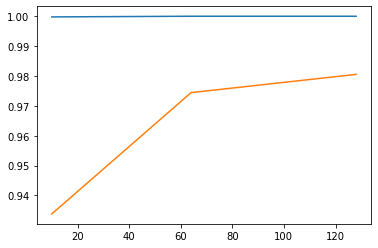

In [18]:
nn_neurons = [(10,10,10),(64,64,64),(128,128,128)]

nn_train_accuracies = []
nn_test_accuracies = []
for neuron in nn_neurons:
    train_accuracy,test_accuracy = cross_validate(neuron)
    nn_train_accuracies.append(np.mean(train_accuracy))
    nn_test_accuracies.append(np.mean(test_accuracy))

plt.plot([i[0] for i in nn_neurons],nn_train_accuracies)
plt.plot([i[0] for i in nn_neurons],nn_test_accuracies)

In [19]:
print('train mean accuracies: ',nn_train_accuracies)
print('test mean accuracies: ',nn_test_accuracies)

train mean accuracies:  [0.9997773324426631, 1.0, 1.0]
test mean accuracies:  [0.9337941285767372, 0.9744165737643998, 0.9805295429208472]


Here again we see the model overfits the training data, but still performs well on the test sets, despite a 6 fold cross validation. We're nearly at a 98% accuracy level. At this point, more data is definitely needed to really validate that our model is accurate.

## Conclusion
In this project we were able to successfully implement both a KNN and Neural Network model that predicted with 98% accuracy the correct digits on the test set. Unfortunately with the Neural Network, when using learning curves, we can clearly see that the model overfit the training data with a 100% accuracy. Although the model is still performing well on the test set, given that we only have under 2000 rows of data, it's hard to truly gauge the accuracy level despite a K-Fold Cross Validation.